In [131]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import  LocalOutlierFactor

In [152]:

# Create a function that takes string input of a SQL query and output a dataframe contain the desired data.
def query_from_db(query):
    # Connection to the posrgreSQL in the airflow container.
    connection = psycopg2.connect(
            host="localhost",
            dbname="airflow",
            port=5532,
            user="postgres",
            password="postgres",
        )
    
    cursor = connection.cursor()
    cursor.execute(query)

    # Get the data from the cursor and make a dataframe for it.
    history_rows = cursor.fetchall()
    df = pd.DataFrame(history_rows)

    # Close the connection,
    cursor.close()
    connection.close()

    return df

In [193]:
# select all ids in table = ethereum
eth = query_from_db("SELECT id, timestamp, price, market_cap, total_volume from coingecko_historic WHERE id = 'ethereum'")
# select all ids in table = bitcoin
btc = query_from_db("SELECT id, timestamp, price, market_cap, total_volume from coingecko_historic WHERE id = 'bitcoin'")

In [194]:
btc

,0,1,2,3,4
0,bitcoin,1678078892240,22362.00823955405,431898530552.6892,15497348287.882515
1,bitcoin,1678082525312,22375.039455087837,432073636503.6055,15965619394.74735
2,bitcoin,1678086057189,22422.125634818287,433026518971.614,16336096947.327412
3,bitcoin,1678089776175,22413.812768997555,432976409654.98444,16541275982.752655
4,bitcoin,1678093343893,22431.198532520255,433137313807.4554,16799194209.257723
...,...,...,...,...,...
3600,bitcoin,1678474851697,19873.05651922205,384283162459.8327,58855643010.24829
3601,bitcoin,1678478447252,20014.94794417126,386502302900.7783,56835669158.30061
3602,bitcoin,1678482177729,19978.40357393128,385853858889.9125,53816931793.481026
3603,bitcoin,1678485723394,20112.688589332083,384668045172.92993,52000141232.537346


In [195]:
# rename columns from range index
eth.columns = ['id', 'timestamp', 'price', 'market_cap', 'total_volume']
btc.columns = ['id', 'timestamp', 'price', 'market_cap', 'total_volume']

In [196]:
# cast timestamp from int to str
btc['timestamp'] = btc['timestamp'].astype(str)
eth['timestamp'] = eth['timestamp'].astype(str)

In [197]:
# convert unix into a readable format 

btc['dt'] = pd.to_datetime(btc['timestamp'], unit='ms').dt.tz_localize('UTC').dt.tz_convert('US/Eastern')
eth['dt'] = pd.to_datetime(eth['timestamp'], unit='ms').dt.tz_localize('UTC').dt.tz_convert('US/Eastern')

In [199]:
# remove timezone info and truncate to seconds

btc['dt'] = btc['dt'].dt.floor('S').dt.tz_localize(None)
eth['dt'] = eth['dt'].dt.floor('S').dt.tz_localize(None)

In [200]:
# make sure in chronological order
btc.sort_values(by='dt', ascending = True, inplace = True)
eth.sort_values(by='dt', ascending = True, inplace = True)

In [201]:
# resolve duplicate values if there are any 

# check timestamps-- all timestamps SHOULD be unique, otherwise drop them 
btc_dupe = btc.duplicated(subset=['timestamp'])
eth_dupe = eth.duplicated(subset=['timestamp'])

if len(btc_dupe) > 1:
    bitcoin = btc.loc[~btc_dupe]
    print("Resolved duplicate values in BTC table")

if len(eth_dupe) > 1:
    ethereum = eth.loc[~eth_dupe]
    print("Resolved duplicate values in ETH table")

Resolved duplicate values in BTC table
Resolved duplicate values in ETH table


Text(0.5, 1.0, 'Ethereum Price from Jan to May 2023')

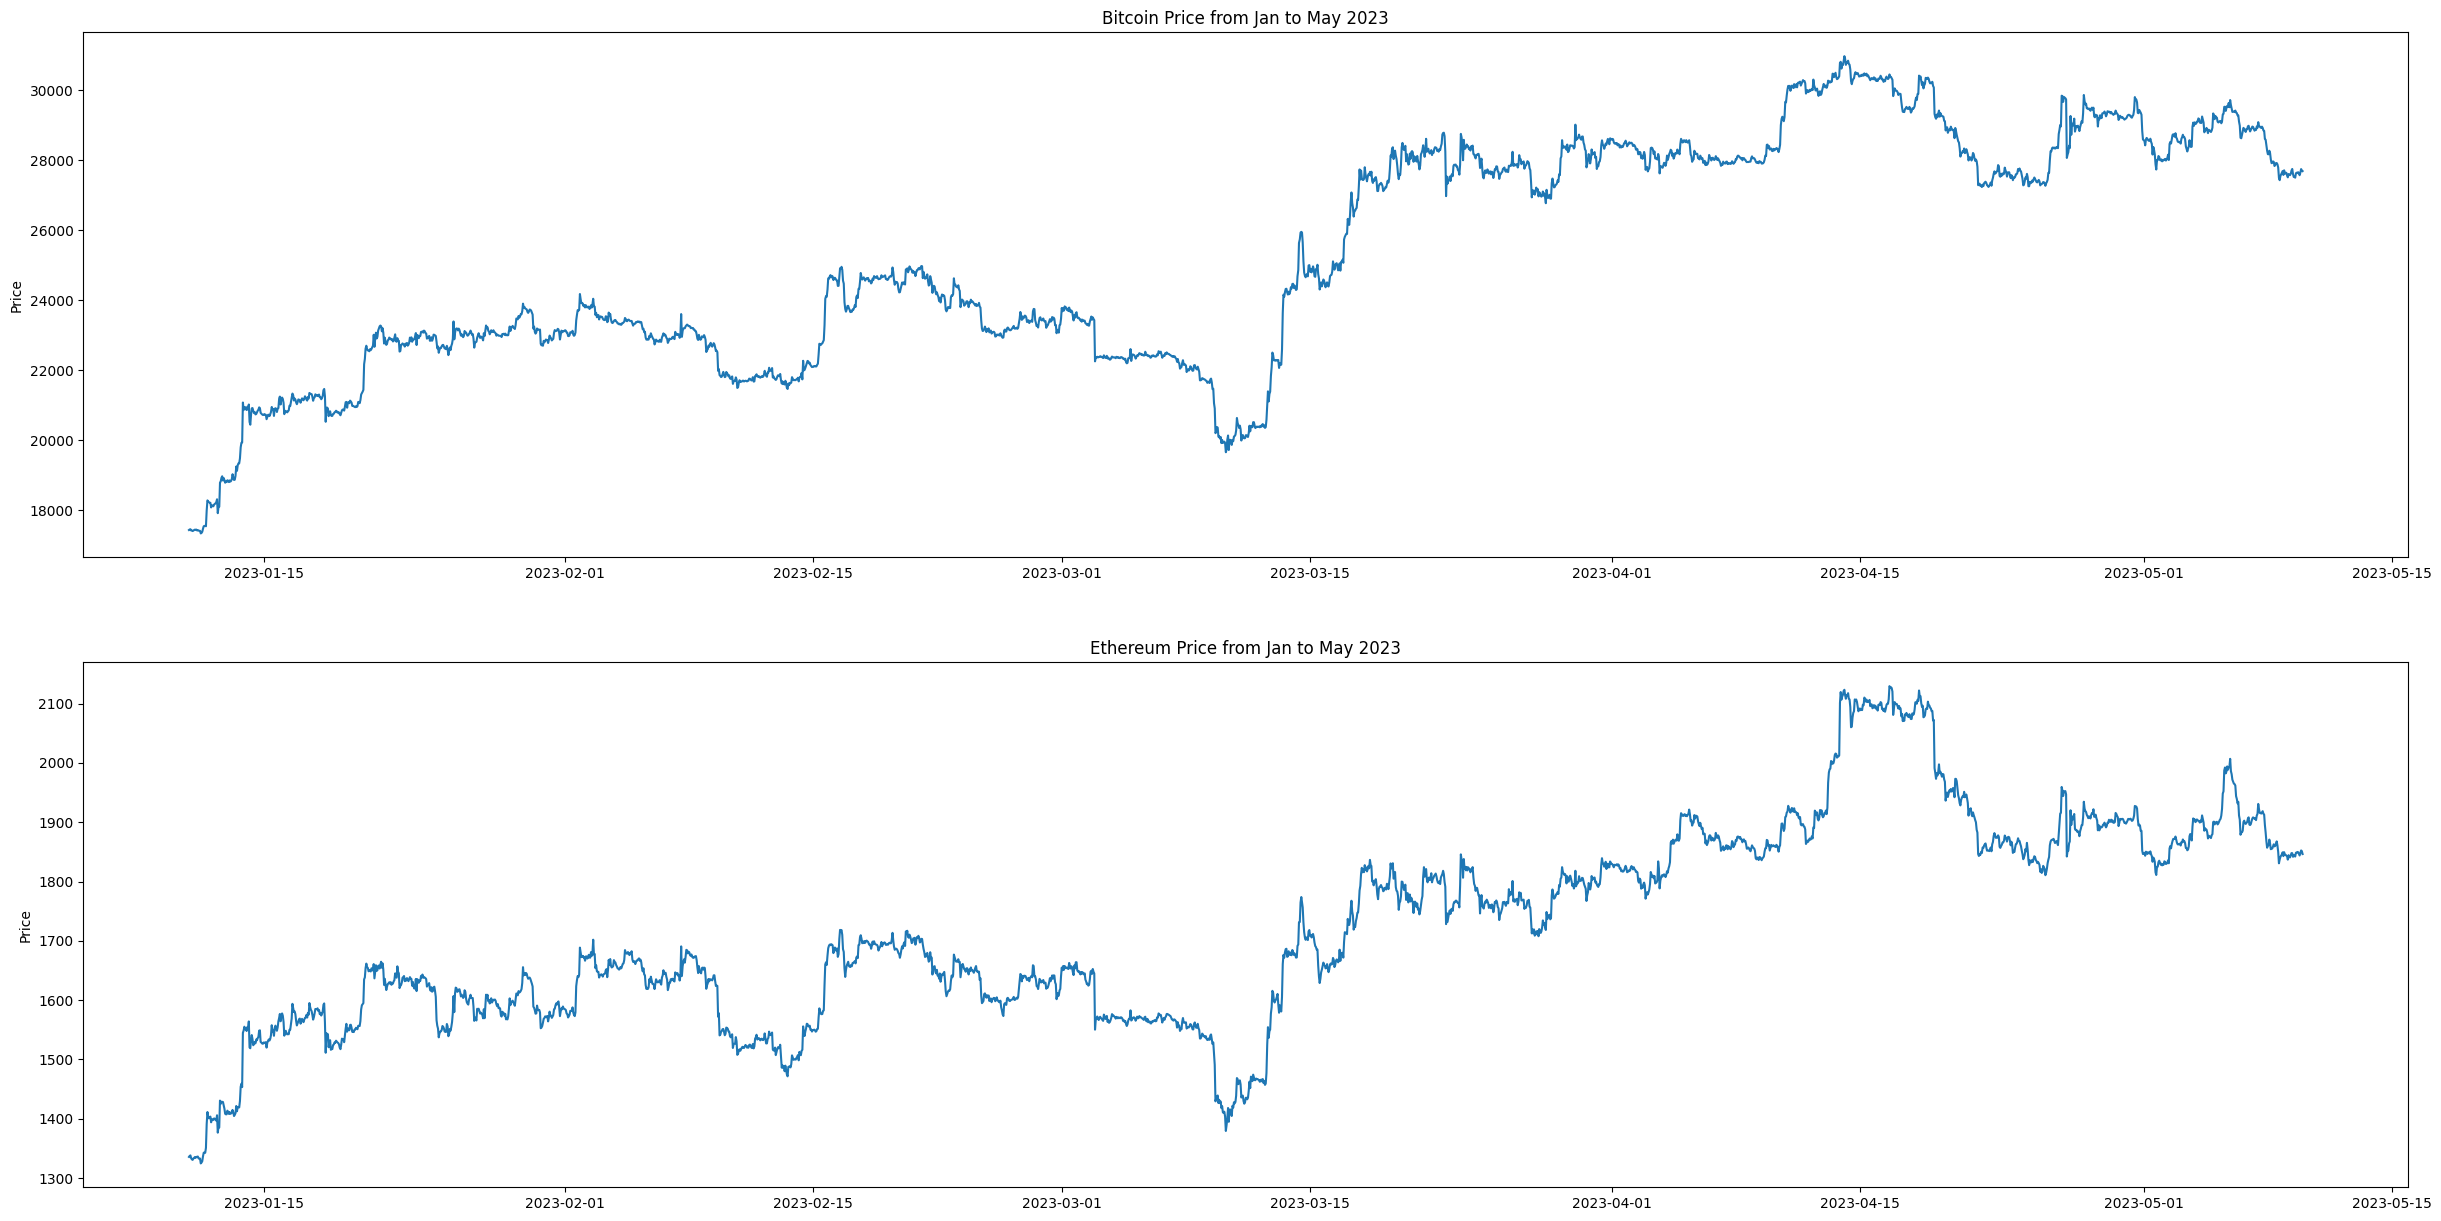

In [202]:
# plot price over time 

plt.figure(figsize = [30,15])
%matplotlib inline 
# displaying the image
plt.subplot(2,1,1)
plt.plot(bitcoin.dt, bitcoin.price)
plt.ylabel("Price")
plt.title("Bitcoin Price from Jan to May 2023")

plt.subplot(2,1,2)
plt.plot(ethereum.dt, ethereum.price)
plt.ylabel("Price")
plt.title("Ethereum Price from Jan to May 2023")

In [207]:
ethereum.reset_index(inplace=True)
bitcoin.reset_index(inplace=True)

In [227]:
# check for outliers in volume

lof = LocalOutlierFactor(n_neighbors=30, contamination=0.05)

btcvol_score = lof.fit_predict(bitcoin[['total_volume']])
bitcoin['outlier'] = btcvol_score

lof2 = LocalOutlierFactor(n_neighbors=30, contamination=0.05)
ethvol_score = lof2.fit_predict(ethereum[['total_volume']])
ethereum['outlier'] = ethvol_score

/var/folders/j2/8gptfrvd0_dfl_yxfcck_hh40000gn/T/ipykernel_4451/2813198558.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bitcoin['outlier'] = btcvol_score
/var/folders/j2/8gptfrvd0_dfl_yxfcck_hh40000gn/T/ipykernel_4451/2813198558.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ethereum['outlier'] = ethvol_score


In [228]:
outindbtc = bitcoin.loc[bitcoin['outlier']==-1]
ol = list(outindbtc.index.values)

outindeth = ethereum.loc[ethereum['outlier']==-1]
el = list(outindeth.index.values)

Text(0.5, 1.0, 'Ethereum Volume from Jan to May 2023')

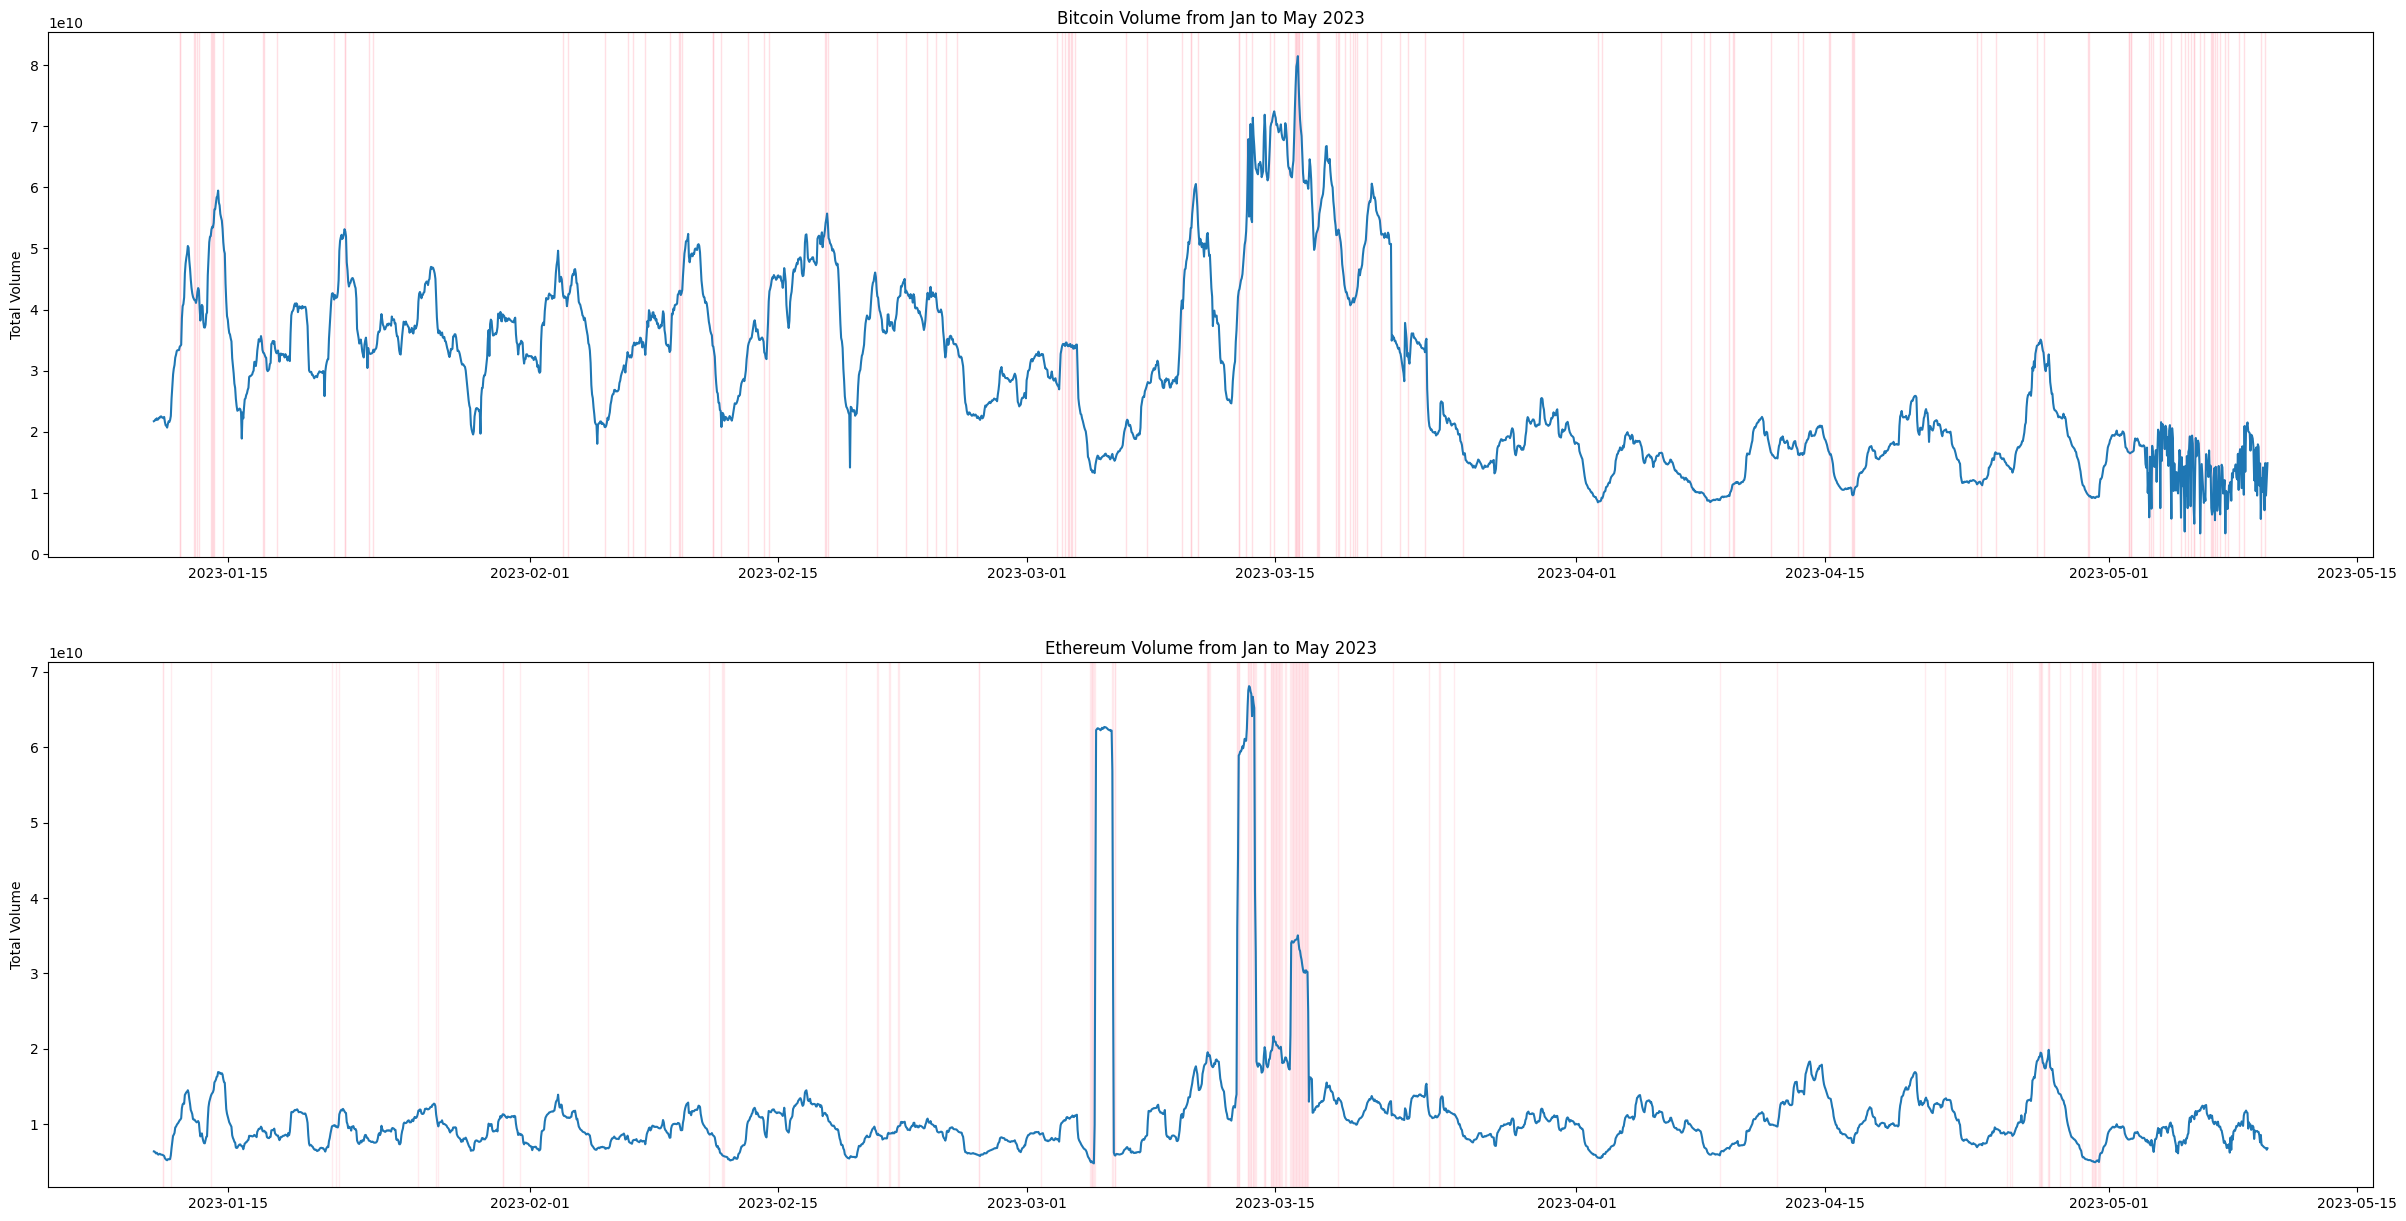

In [229]:
# plot volume over time 

# volume the number of units traded in a market during a given time
# it is a measurement of the number of individual units of an asset that changed hands during that period

plt.figure(figsize = [30,15])
%matplotlib inline 
# displaying the image
plt.subplot(2,1,1)
plt.plot(bitcoin.dt, bitcoin.total_volume)
for i in ol:
    plt.axvspan(bitcoin.dt[i], bitcoin.dt[i], 
            label="Labeled",color="pink", alpha=0.5, ymin=0, ymax=1e10)
plt.ylabel("Total Volume")
plt.title("Bitcoin Volume from Jan to May 2023")

plt.subplot(2,1,2)
plt.plot(ethereum.dt, ethereum.total_volume)
for x in el:
    plt.axvspan(ethereum.dt[x], ethereum.dt[x], 
            label="Labeled",color="pink", alpha=0.3, ymin=0, ymax=1e10)
plt.ylabel("Total Volume")
plt.title("Ethereum Volume from Jan to May 2023")

In [230]:
# One way to think about market cap is as a rough gauge for how stable an asset is likely to be

lof3 = LocalOutlierFactor(n_neighbors=30, contamination=0.05)
mcbtc = lof3.fit_predict(bitcoin[['market_cap']])
bitcoin['outlier_mc'] = mcbtc

lof4 = LocalOutlierFactor(n_neighbors=30, contamination=0.05)
mceth = lof4.fit_predict(ethereum[['market_cap']])
ethereum['outlier_mc'] = mceth

mc_bit = bitcoin.loc[bitcoin['outlier_mc']==-1]
ol_mc = list(mc_bit.index.values)

mc_eth = ethereum.loc[ethereum['outlier_mc']==-1]
el_mc = list(mc_eth.index.values)

/var/folders/j2/8gptfrvd0_dfl_yxfcck_hh40000gn/T/ipykernel_4451/2790617404.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bitcoin['outlier_mc'] = mcbtc
/var/folders/j2/8gptfrvd0_dfl_yxfcck_hh40000gn/T/ipykernel_4451/2790617404.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ethereum['outlier_mc'] = mceth


Text(0.5, 1.0, 'Ethereum Market Cap from Jan to May 2023')

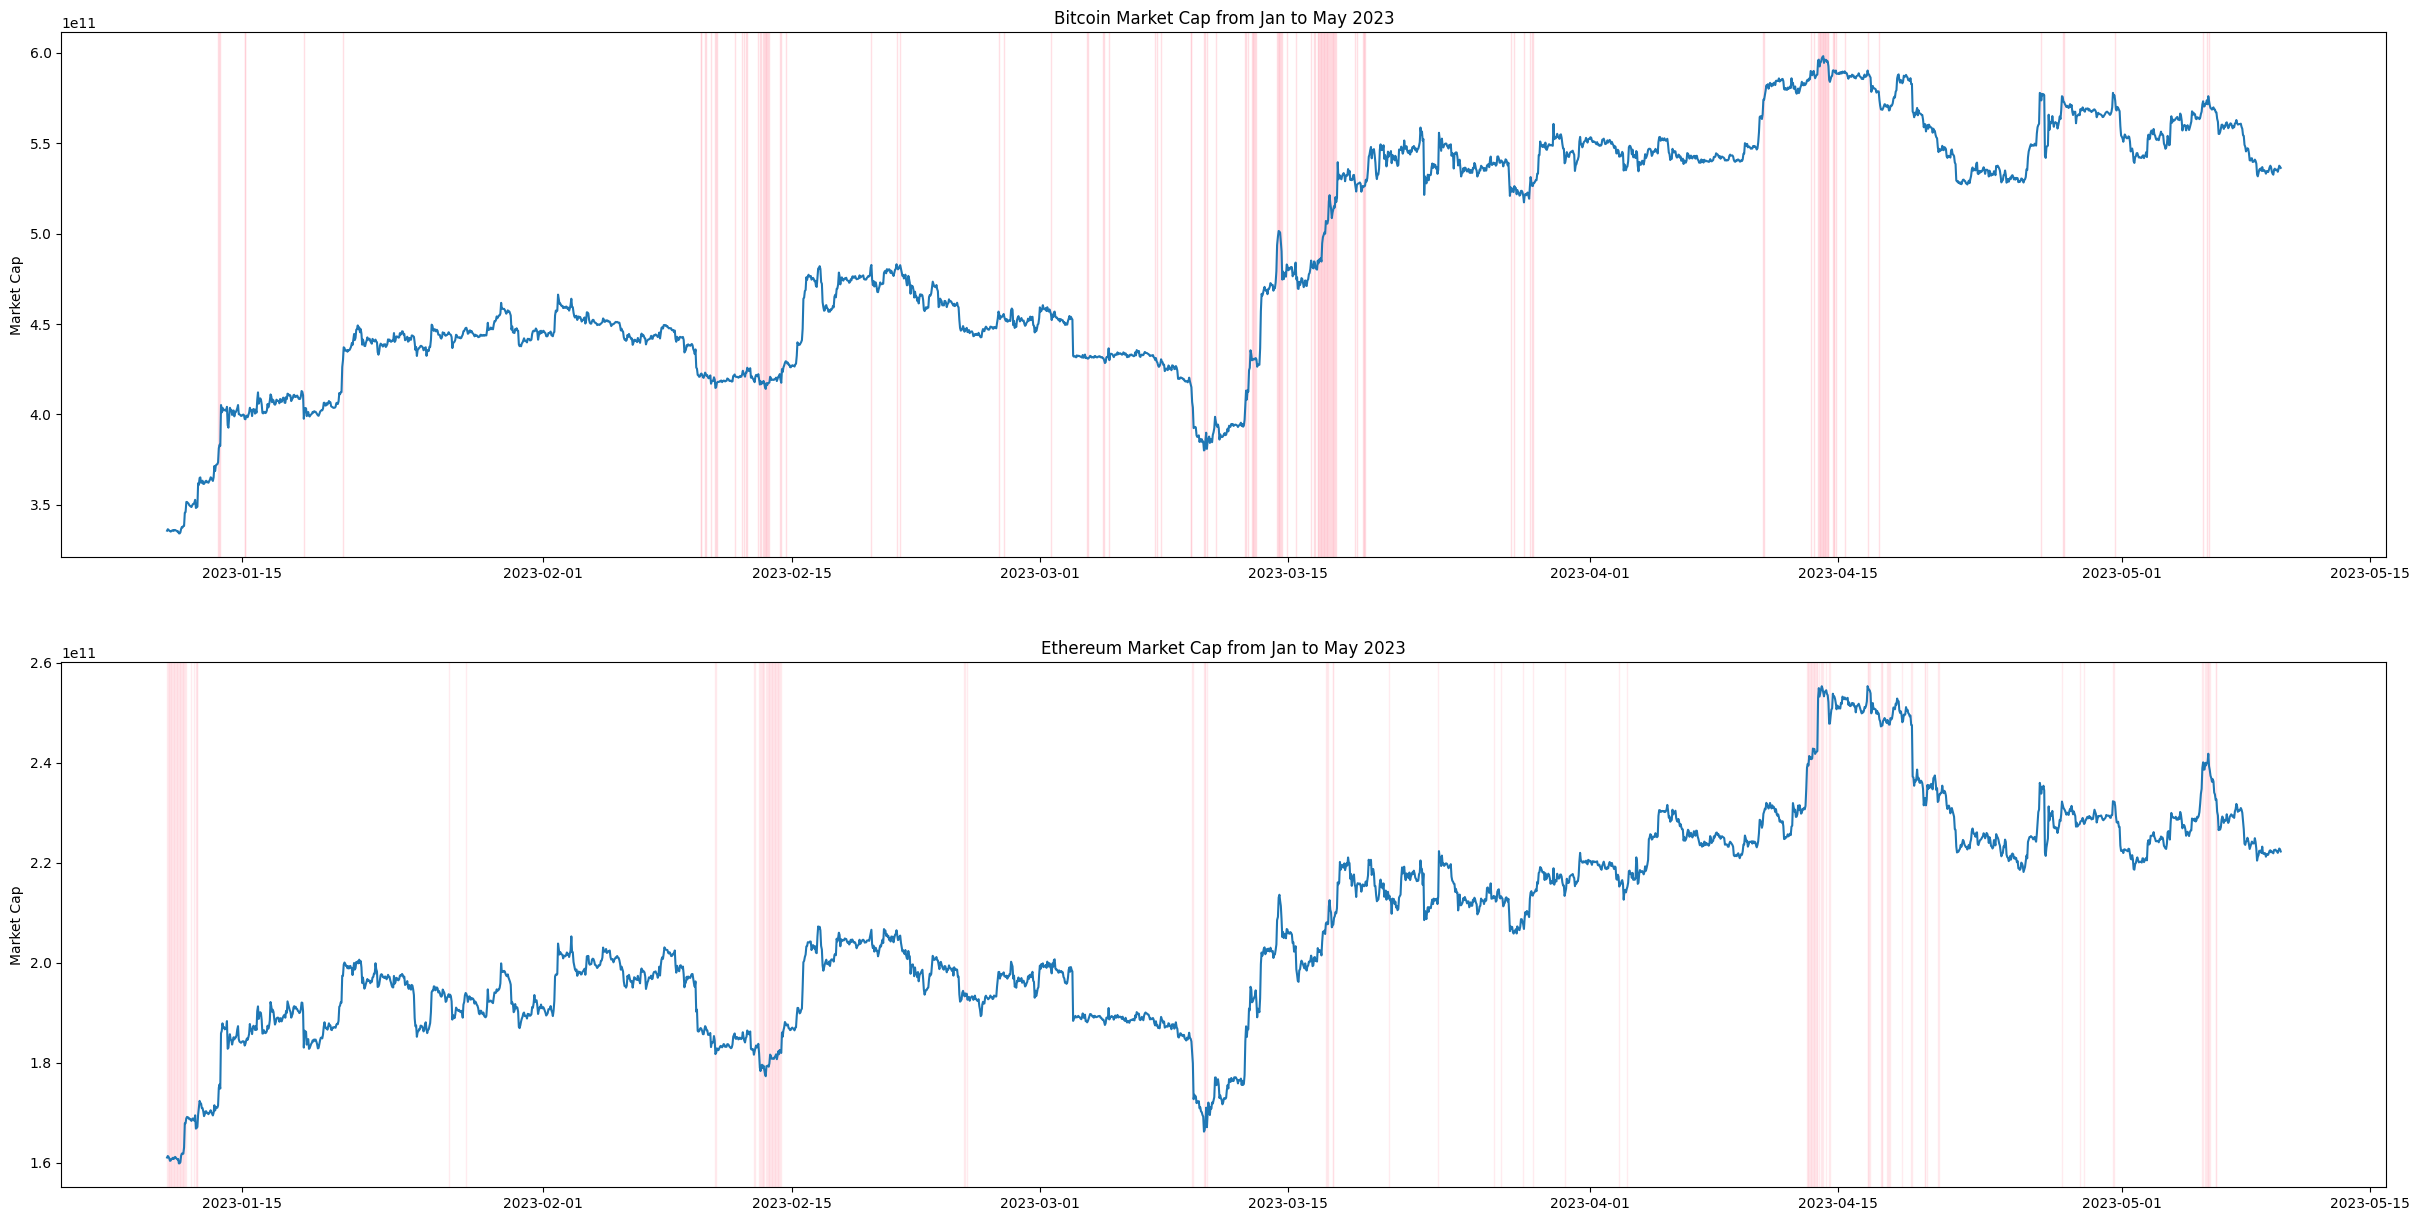

In [232]:
plt.figure(figsize = [30,15])
%matplotlib inline 
# displaying the image
plt.subplot(2,1,1)
plt.plot(bitcoin.dt, bitcoin.market_cap)
for i in ol_mc:
    plt.axvspan(bitcoin.dt[i], bitcoin.dt[i], 
            label="Labeled",color="pink", alpha=0.5, ymin=0, ymax=1e10)
plt.ylabel("Market Cap")
plt.title("Bitcoin Market Cap from Jan to May 2023")

plt.subplot(2,1,2)
plt.plot(ethereum.dt, ethereum.market_cap)
for x in el_mc:
    plt.axvspan(ethereum.dt[x], ethereum.dt[x], 
            label="Labeled",color="pink", alpha=0.3, ymin=0, ymax=1e10)
plt.ylabel("Market Cap")
plt.title("Ethereum Market Cap from Jan to May 2023")

In [233]:
bitcoin

,index,id,timestamp,price,market_cap,total_volume,dt,outlier,outlier_mc
0,2184,bitcoin,1673395296981,17440.383890840567,335743942932.3494,21736821684.1694,2023-01-10 19:01:36,1,1
1,2185,bitcoin,1673398827105,17456.10061880035,336564284048.42487,21806087519.377533,2023-01-10 20:00:27,1,1
2,2186,bitcoin,1673402446852,17462.653144945027,336233438972.7385,22009253608.207054,2023-01-10 21:00:46,1,1
3,2187,bitcoin,1673406098961,17426.61561837987,335713159189.0227,21952599718.58629,2023-01-10 22:01:38,1,1
4,2188,bitcoin,1673409646925,17426.665167968,335446307588.9751,22209009278.37667,2023-01-10 23:00:46,1,1
...,...,...,...,...,...,...,...,...,...
2860,2179,bitcoin,1683673237881,27577.36086358994,534161955089.65704,7172655650.55621,2023-05-09 19:00:37,-1,1
2861,2180,bitcoin,1683676840574,27651.942050027224,535590432952.3462,14885371462.615923,2023-05-09 20:00:40,1,1
2862,2181,bitcoin,1683680407604,27752.56928261187,537528176597.4389,9578577613.418144,2023-05-09 21:00:07,1,1
2863,2182,bitcoin,1683684007180,27711.601622021073,536922363805.5073,12110057320.81694,2023-05-09 22:00:07,1,1
